# CNN

## Imports

Nothing to see here.

In [1]:
import random

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
from PIL import Image
from tensorflow.keras import layers, losses, models

from src.util import (
    load_star_galaxy_dataset,
    star_galaxy_split,
    train_val_test_split,
    STAR,
    GALAXY,
)

%matplotlib inline

2023-04-17 17:28:21.521937: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 17:28:21.543569: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-17 17:28:21.543929: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-17 17:28:21.951517: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Dataset

### Load Dataset

Here we load the whole dataset and store the target values as constants.

In [2]:
# Load dataset
dataset = load_star_galaxy_dataset()
print(f"{dataset.DESCR}\n")
print(f"Dataset size: {len(dataset.image)} images")

This is a simple dataset consisting of ~3000 64x64 images of stars and ~1000 images of galaxies. The images were captured by the in-house 1.3m telescope of the observatory situated in Devasthal, Nainital, India.

Dataset size: 3986 images


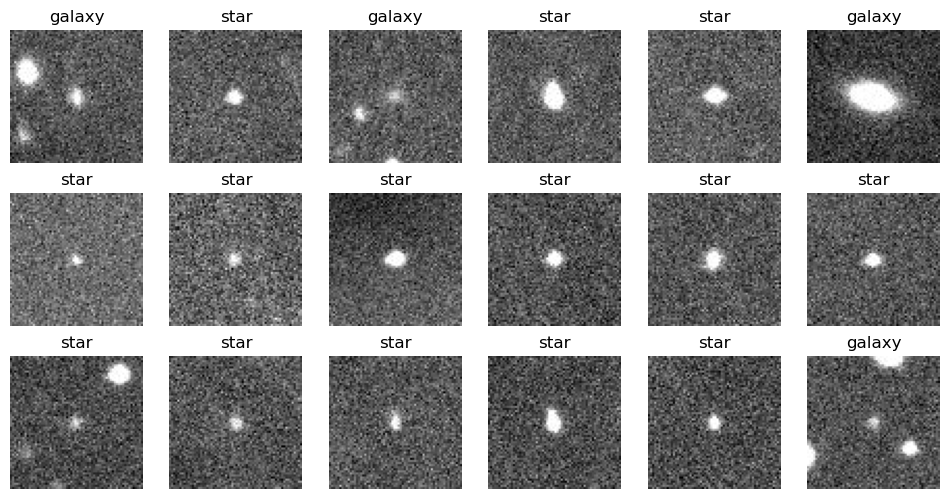

In [3]:
w, h = 6, 3

_, axs_list = plt.subplots(h, w, figsize=(2 * w, 2 * h))

_i = 0  # Index traversing the random indices
indices = np.random.choice(len(dataset.image), size=(w * h))
for axs in axs_list:
    for ax in axs:
        i = indices[_i]
        ax.axis("off")
        ax.imshow(dataset.image[i], cmap="gray")
        ax.set_title(dataset.target_names[dataset.target[i]])
        _i += 1

## Building the Layers

Much like an onion or an ogre, a CNN model consists of layers.

The first few layers work with the input images more intuitively. The model takes in grayscale images, rescaling the `[0, 255]` values to `[0, 1]` (in both training and inference).

It also (in training) randomly flips and rotates images. This is helpful to the model since we have a relatively small dataset.

In [4]:
model = models.Sequential()
model.add(layers.Input(shape=(64, 64, 1)))  # 64x64 grayscale images
model.add(layers.Rescaling(scale=(1.0 / 255)))  # Rescale values to [0, 1]
# model.add(layers.RandomFlip())
# model.add(layers.RandomRotation(factor=0.2))

2023-04-17 17:28:23.855515: E tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:266] failed call to cuInit: CUDA_ERROR_NO_DEVICE: no CUDA-capable device is detected


The model then goes through convolutions.

In [5]:
# First convolution
model.add(layers.Conv2D(filters=32, kernel_size=3, activation="relu"))

# Second convolution
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Dropout(0.25))

# Third convolution
model.add(layers.Conv2D(filters=64, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Dropout(0.25))

# Fourth convolution
model.add(layers.Conv2D(filters=128, kernel_size=3, activation="relu"))
model.add(layers.MaxPool2D(pool_size=2))
model.add(layers.Dropout(0.25))

Finally, the model flattens the processed data and feeds it into a Deep Neural Network.

In [6]:
# Flatten processed image data
model.add(layers.Flatten())

# Hidden layers
model.add(layers.Dense(units=512, activation="relu"))
model.add(layers.Dense(units=32, activation="relu"))
model.add(layers.Dropout(0.6))

# Output layer
model.add(layers.Dense(units=2))

Now, let's see the model's layers.

In [7]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 64, 64, 1)         0         
                                                                 
 conv2d (Conv2D)             (None, 62, 62, 32)        320       
                                                                 
 conv2d_1 (Conv2D)           (None, 60, 60, 64)        18496     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 30, 30, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 30, 30, 64)        0         
                                                                 
 conv2d_2 (Conv2D)           (None, 28, 28, 64)        36928     
                                                        

Before the model can be trained, we need to compile it.

In [8]:
model.compile(
    optimizer="adam",
    loss=losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=["accuracy"],
)

## Training the Model

In [9]:
def train_test_model(model, x, y, epochs: int = 30):
    # Split dataset
    x_train, x_val, x_test, y_train, y_val, y_test = train_val_test_split(
        x,
        y,
        stratify=y,
    )

    # Train model
    history = model.fit(
        x_train,
        y_train,
        epochs=epochs,
        validation_data=(x_val, y_val),
        verbose=1,
    )

    # Evaluate model
    for _x, _y, _name in zip(
        [dataset.image, x, x_train, x_val, x_test],
        [dataset.target, y, y_train, y_val, y_test],
        ["FULL", "GIVEN", "TRAIN", "VAL", "TEST"],
    ):
        print()
        print(_name)
        print("-" * len(_name))
        print("overall", end="\t\t")
        model.evaluate(_x, _y, verbose=2)

        stars, galaxies = star_galaxy_split(_x, _y)
        print("stars", end="\t\t")
        model.evaluate(stars, np.full(len(stars), STAR), verbose=2)
        print("galaxies", end="\t")
        model.evaluate(galaxies, np.full(len(galaxies), GALAXY), verbose=2)

    return history

In [10]:
def plot_history(history) -> None:
    pd.DataFrame(history.history).plot(figsize=(8, 5))
    plt.grid(True)
    plt.gca().set_ylim(0, 1)
    plt.xlabel("epoch")
    plt.show()

In [11]:
history = train_test_model(model=model, x=dataset.image, y=dataset.target)

Epoch 1/30
100/100 [==============================] - 7s 67ms/step - loss: 0.5755 - accuracy: 0.7600 - val_loss: 0.5955 - val_accuracy: 0.7519
Epoch 2/30
100/100 [==============================] - 6s 63ms/step - loss: 0.5049 - accuracy: 0.7607 - val_loss: 0.3936 - val_accuracy: 0.7519
Epoch 3/30
100/100 [==============================] - 6s 64ms/step - loss: 0.4080 - accuracy: 0.7895 - val_loss: 0.3454 - val_accuracy: 0.8521
Epoch 4/30
100/100 [==============================] - 6s 63ms/step - loss: 0.3765 - accuracy: 0.8416 - val_loss: 0.3052 - val_accuracy: 0.8747
Epoch 5/30
100/100 [==============================] - 6s 63ms/step - loss: 0.3859 - accuracy: 0.8403 - val_loss: 0.3035 - val_accuracy: 0.8747
Epoch 6/30
100/100 [==============================] - 6s 63ms/step - loss: 0.3384 - accuracy: 0.8598 - val_loss: 0.2779 - val_accuracy: 0.8922
Epoch 7/30
100/100 [==============================] - 6s 63ms/step - loss: 0.3257 - accuracy: 0.8654 - val_loss: 0.3112 - val_accuracy: 0.8897

## Evaluating the Model

Let's see how the model performed with each epoch.

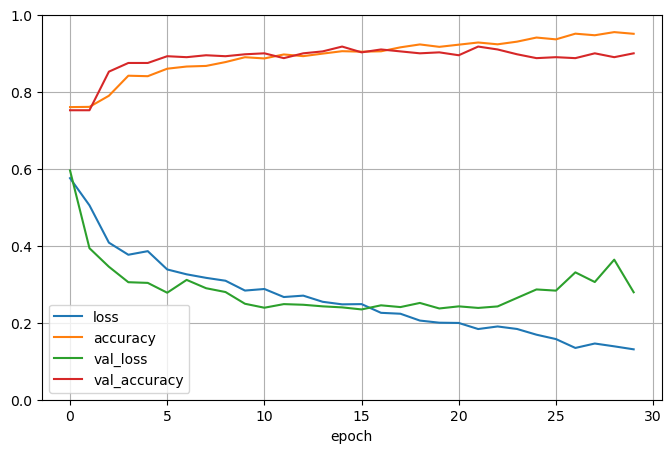

In [12]:
plot_history(history=history)

## Problem

The dataset we use has far more images of stars than galaxies, almost 3 times as many. This presents a challenge when it comes to classification, as the model could easily guess "star" for any given image and have essentially a 1/4 chance of being right.

In [13]:
all_stars, all_galaxies = star_galaxy_split(dataset.image, dataset.target)
print(f"stars: {len(all_stars)} images")
print(f"galaxies: {len(all_galaxies)} images")

stars: 3044 images
galaxies: 942 images


## Attempt at a Solution

Our attempt at| solving this problem is to only use a subset of the entire dataset. We use a sample of about 1,000 random images of the stars, to have an even number of both classes in training and testing.

In [14]:
dataset_even = load_star_galaxy_dataset(even=True)
print(f"'Even' dataset size: {len(dataset_even.image)} images")

'Even' dataset size: 1884 images


In [15]:
history_even = train_test_model(
    model=model, x=dataset_even.image, y=dataset_even.target
)

Epoch 1/30
48/48 [==============================] - 3s 62ms/step - loss: 0.2238 - accuracy: 0.9217 - val_loss: 0.2567 - val_accuracy: 0.9628
Epoch 2/30
48/48 [==============================] - 3s 62ms/step - loss: 0.2091 - accuracy: 0.9197 - val_loss: 0.2713 - val_accuracy: 0.9521
Epoch 3/30
48/48 [==============================] - 3s 62ms/step - loss: 0.2289 - accuracy: 0.9104 - val_loss: 0.2770 - val_accuracy: 0.9521
Epoch 4/30
48/48 [==============================] - 3s 61ms/step - loss: 0.1581 - accuracy: 0.9423 - val_loss: 0.3848 - val_accuracy: 0.9415
Epoch 5/30
48/48 [==============================] - 3s 62ms/step - loss: 0.1438 - accuracy: 0.9469 - val_loss: 0.3531 - val_accuracy: 0.9362
Epoch 6/30
48/48 [==============================] - 3s 61ms/step - loss: 0.1340 - accuracy: 0.9463 - val_loss: 0.2901 - val_accuracy: 0.9415
Epoch 7/30
48/48 [==============================] - 3s 64ms/step - loss: 0.1146 - accuracy: 0.9562 - val_loss: 0.3612 - val_accuracy: 0.9521
Epoch 8/30
48

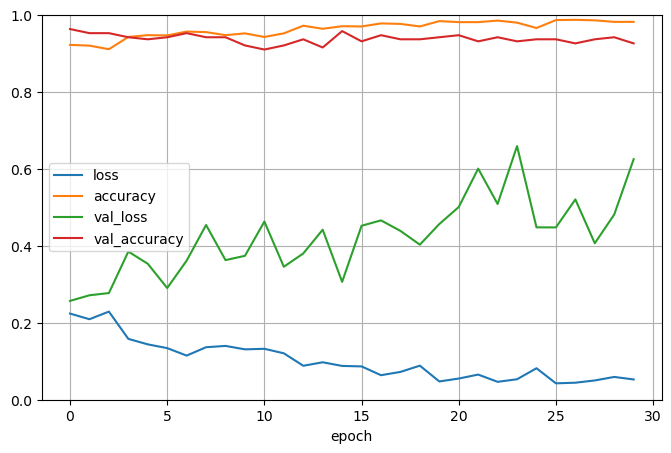

In [16]:
plot_history(history=history_even)

## Conclusions

TBD